In [1]:
library(showtext)
showtext_auto()
library("rjags")

Loading required package: sysfonts
Loading required package: showtextdb
Warning message:
“package ‘rjags’ was built under R version 3.6.3”Loading required package: coda
Warning message:
“package ‘coda’ was built under R version 3.6.3”Linked to JAGS 4.3.0
Loaded modules: basemod,bugs


## Exercise 1: Bernoulli process

Given a set of observation, coming from a Bernoulli process, we want to infer the probability $p$ of the process from the sequence of success/failure, and predict the number of successes in the future.

In [3]:
#The observed sequence is 
X <- c(0,0,0,0,0,0,0,1,0,0,
      0,0,0,0,0,0,0,0,0,0,
      0,1,0,1,0,0,0,0,0,0,
      0,0,0,0,0,0,0,0,0,0,
      0,0,0,1,0,0,0,0,0,1,
      0,1,0,0,0,0,0,1,0,0,
      0,0,0,0,1,0,0,0,1,0,
      0,0,0,0,0,0,0,0,1,1,
      0,1,0,0,1,0,0,0,0,0,
      0,0,0,0,1,0,0,1,0,1)

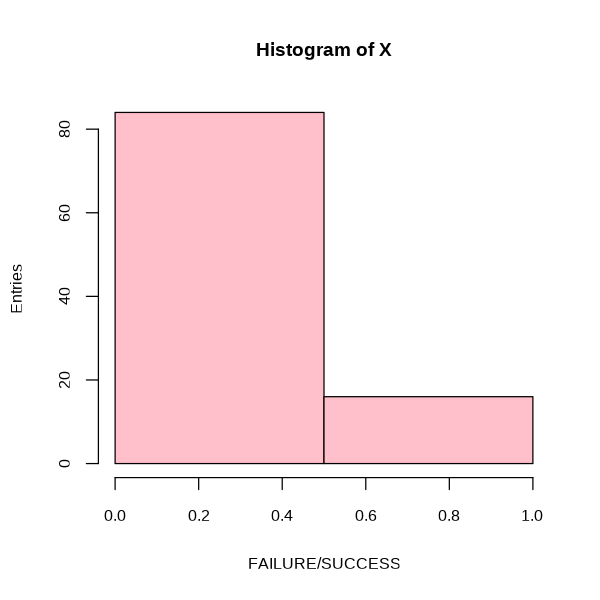

In [4]:
options(repr.plot.width = 5, repr.plot.height = 5)

hist(X,breaks=2,col="pink",
    xlab="FAILURE/SUCCESS",
    ylab="Entries")

### BUGS model and parameters

#### Bernoulli process

In [6]:
data <- NULL
data$X <- X          #set of observations
data$n <- length(X)  #Those to be considered 

data$n_next <- 10    #Predictions

In [17]:
model <- "s13_inf_p_pred.bug"
jm <- jags.model(model,data)

Warning message in jags.model(model, data):
“Unused variable "n" in data”

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 100
   Unobserved stochastic nodes: 2
   Total graph size: 104

Initializing model



In [18]:
#Update the Markov chain (Burn-in)
update(jm, 1000)
chain <- coda.samples(jm, c("p","y"), n.iter=10000)
print(summary(chain))


Iterations = 1001:11000
Thinning interval = 1 
Number of chains = 1 
Sample size per chain = 10000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

    Mean      SD  Naive SE Time-series SE
p 0.1672 0.03655 0.0003655      0.0003655
y 1.6656 1.23488 0.0123488      0.0115919

2. Quantiles for each variable:

   2.5%    25%    50%   75%  97.5%
p 0.102 0.1411 0.1648 0.191 0.2456
y 0.000 1.0000 2.0000 2.000 4.0000




 Correlation matrix: 
          p         y
p 1.0000000 0.3131491
y 0.3131491 1.0000000


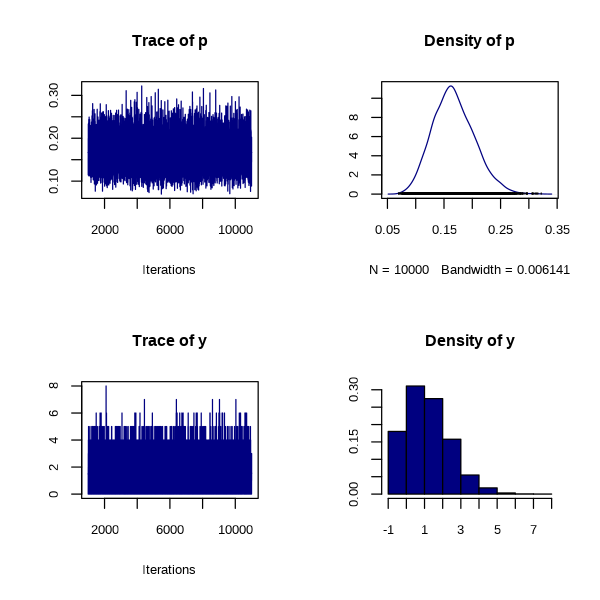

In [21]:
plot(chain, col="navy")

#Let's format our chain
chain.df <- as.data.frame(as.mcmc(chain))
cat(sprintf("\n Correlation matrix: \n"))
print(cor(chain.df))

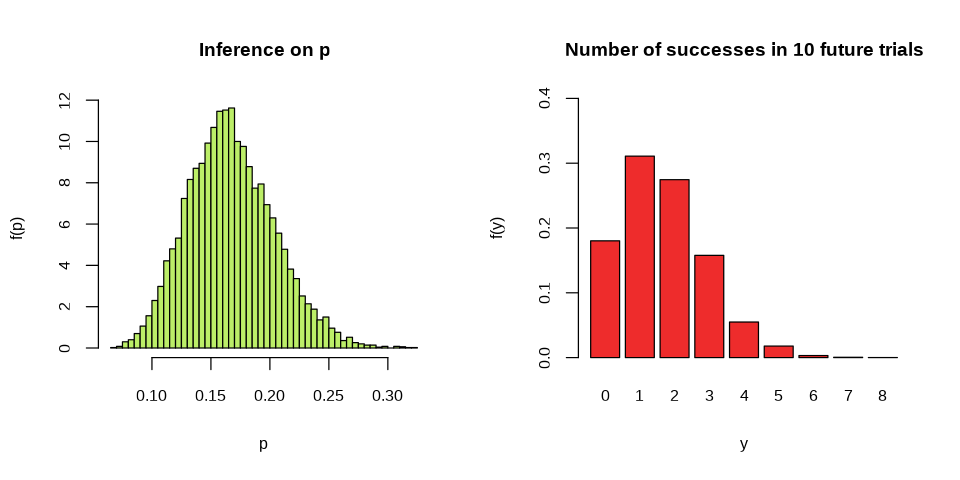

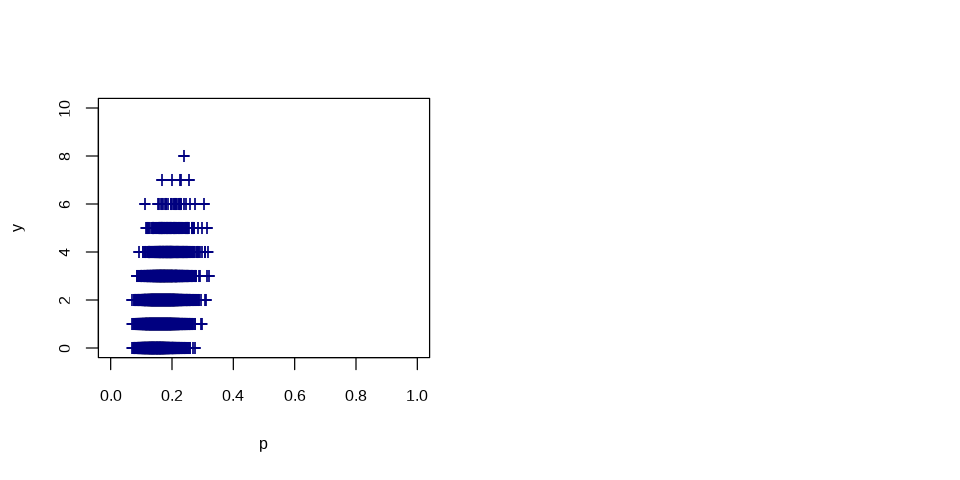

In [25]:
options(repr.plot.width = 8, repr.plot.height = 4)
par(mfrow=c(1,2),mfcol=c(1,2))
#
# P inference result
#
hist(chain.df$p, nc=50, prob=TRUE, col="darkolivegreen2",
    xlab="p", ylab="f(p)", main="Inference on p")

#
# next data prediction probability
#
ty <- table(chain.df$y)
barplot(ty/sum(ty), col='firebrick2', xlab="y", ylab="f(y)",
       ylim=c(0,0.40),
       main=sprintf("Number of successes in %d future trials", data$n_next))

#
#Correlation between p and predicted variable
#

plot(chain.df$p, chain.df$y, xlab="p", ylab="y", main="",
    pch="+", col="navy",cex=1.5,
    xlim=c(0,1), ylim=c(0,10))

#### Poisson inference

Given the number of counts from a ionizing radiation detector, we want to infer the parameter $\lambda$ of the underlying Poisson process

##### The bugs model:

In [ ]:
#poisson_inference.bug
#model {
    # data likelihood
#    X ~ dpois(lambda);
    # a uniform prior for lambda
#    lambda ~ dexp(0.00001)
    # Predicted data , given lambda
#    Y ~ dpois(lambda);
#}


##### The data:

In [2]:
data <- NULL
data$X <- 100 # number of counts

##### The JAGDS model:

In [4]:
library("rjags")
model <- "poisson_inference.bug"
jm <- jags.model(model, data)

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 1
   Unobserved stochastic nodes: 2
   Total graph size: 4

Initializing model



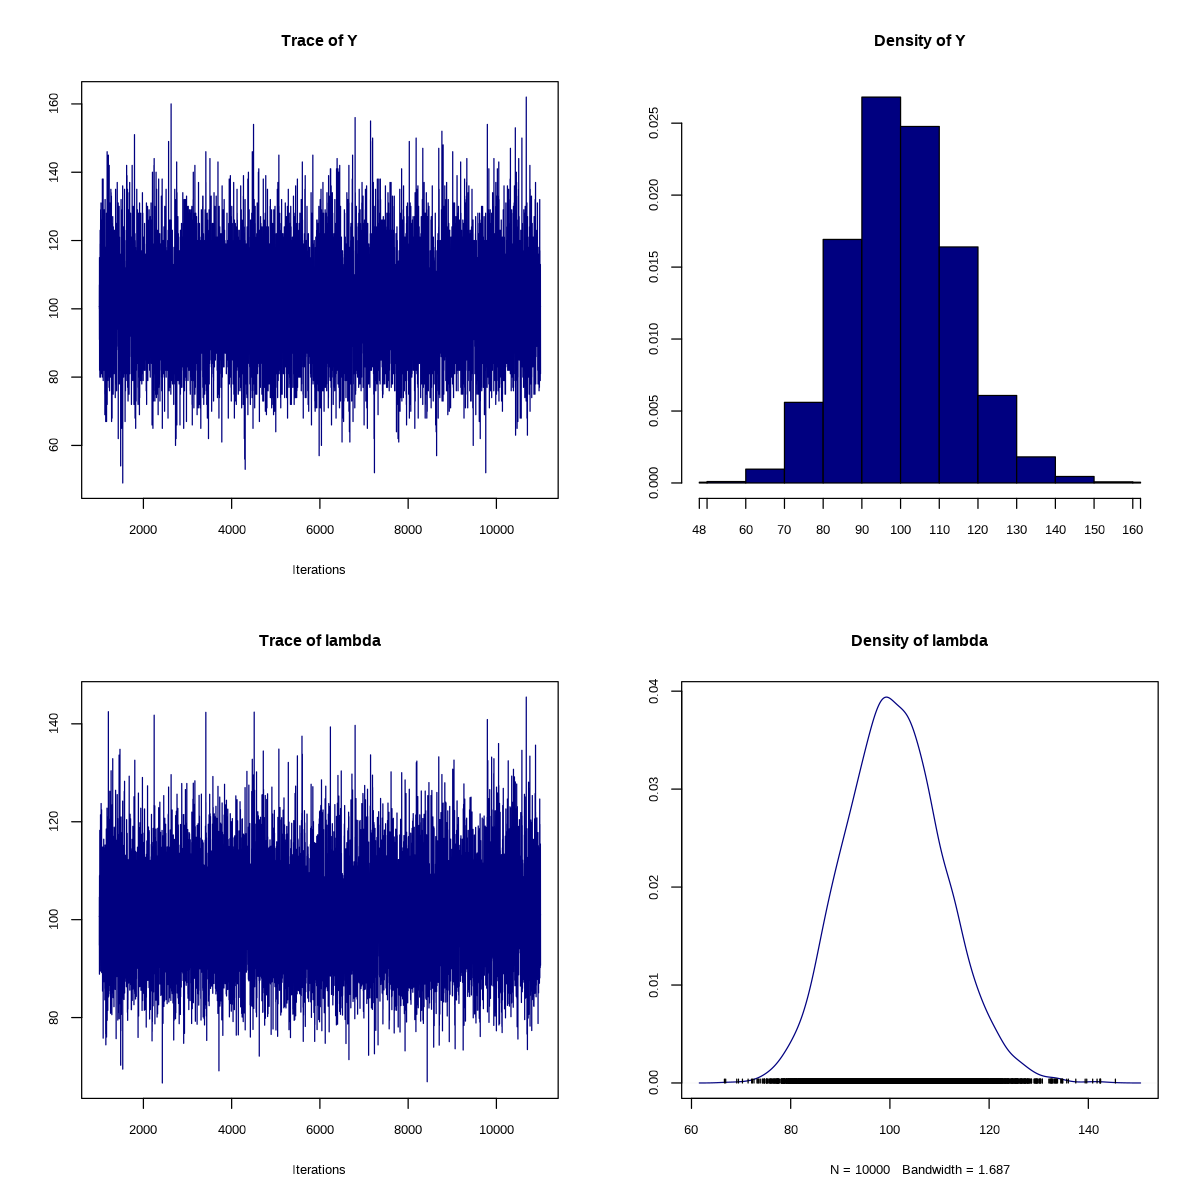

In [5]:
#update the Markov chain (Burn-in)
update(jm, 1000)

chain <- coda.samples(jm, c("lambda","Y"), n.iter=10000)

options(repr.plot.width = 10, repr.plot.height = 10)
plot(chain, col="navy")


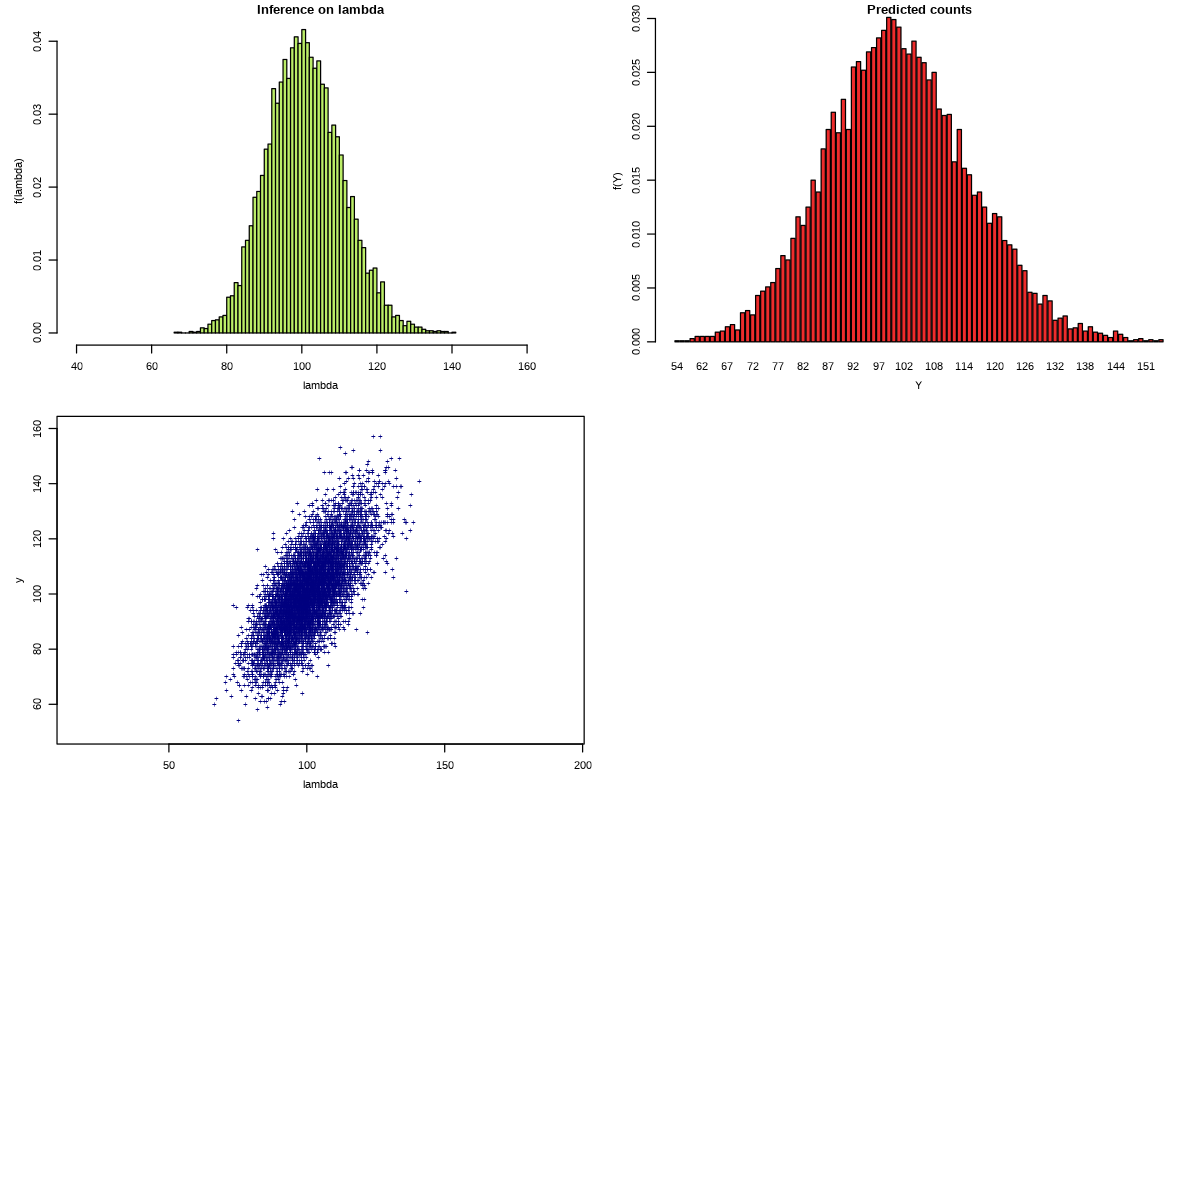

In [33]:
#Let's format our chain
chain.df <- as.data.frame(as.mcmc(chain))


#
#Probability plots
par(mfrow=c(3,2), mgp=c(2.0,0.8,0), mar=c(3.5,3.5,1,1), oma=0.1*c(1,1,1,1))
hist(chain.df$lambda, nc=100, prob=TRUE, col="darkolivegreen2",
    xlim=c(40,170),
    xlab="lambda", ylab="f(lambda)",main="Inference on lambda")

ty <- table(chain.df$Y)
barplot(ty/sum(ty), col="firebrick2", xlab="Y", ylab="f(Y)",
       #ylim=c(0,0.40),
        main=sprintf("Predicted counts"))

#
# And present / future prediction correlations
plot(chain.df$lambda, chain.df$Y, xlab="lambda", ylab="y",main="",
    pch="+", col="navy", cex=0.75, asp=1,
    xlim=c(50,160), ylim=c(50,160))

#### Normal inference: